In [1]:
# Diagnostic: compute pixels->meters from the first NPZ (if available)
from pathlib import Path
from utils.sonar_utils import load_cone_run_npz
npz_files = list(Path('exports/outputs').glob('*_cones.npz'))
if npz_files:
    cones, ts, extent, meta = load_cone_run_npz(npz_files[0])
    x_min, x_max, y_min, y_max = extent
    px_per_m_x = cones.shape[2] / (x_max - x_min)
    px_per_m_y = cones.shape[1] / (y_max - y_min)
    px2m_x = 1.0 / px_per_m_x
    px2m_y = 1.0 / px_per_m_y
    print(f"Loaded NPZ: {npz_files[0].name}")
    print(f"Extent: {extent}")
    print(f"px2m (x,y): {px2m_x:.4f}, {px2m_y:.4f}")
else:
    print('No NPZ cone files found in exports/outputs')


Loaded NPZ: 2024-08-22_14-06-43_data_cones.npz
Extent: (-8.660254037844386, 8.660254037844386, 0.0, 10.0)
px2m (x,y): 0.0192, 0.0143


In [2]:
# Centralized sonar defaults (inserted by sweep)
from utils.sonar_config import SONAR_VIS_DEFAULTS
sonar_config = SONAR_VIS_DEFAULTS.copy()
# Backwards-compatible variable names used in older notebooks
RANGE_MIN_M = sonar_config['range_min_m']
RANGE_MAX_M = sonar_config['range_max_m']
DISPLAY_RANGE_MAX_M = sonar_config['display_range_max_m']

# If an exported NPZ/MP4 sidecar is available, downstream cells will prefer that metadata
# Optional: override defaults below, e.g.
# DISPLAY_RANGE_MAX_M = 10.0


# Simple Image Analysis with CV2

This notebook demonstrates:
1. **Pick a frame** from NPZ files and save it locally
2. **Use standard cv2 functions** directly for image processing
3. **Experiment** with different OpenCV operations

In [3]:
import utils.sonar_image_analysis as iau
import matplotlib.pyplot as plt

# Prefer selecting by bag ID (part of the NPZ filename) instead of a numeric index.
# Set TARGET_BAG to a substring that appears in the NPZ filename (e.g. '2024-08-22_14-29-05')
TARGET_BAG = '2024-08-22_14-29-05'  # change this to your desired bag ID

# Find NPZ files and pick the one matching TARGET_BAG
files = iau.get_available_npz_files()
if not files:
    raise FileNotFoundError('No NPZ files found in exports/outputs')
matches = [p for p in files if TARGET_BAG in p.name]
if not matches:
    # Help the user by listing available NPZ files
    print(f'No NPZ file matched TARGET_BAG={TARGET_BAG!r}')
    print('Available NPZ files:')
    for i,p in enumerate(files):
        print(f'  {i}: {p.name}')
    raise ValueError(f'No NPZ file contains "{TARGET_BAG}" in its name')
# If multiple matches, choose the most recently modified one
selected = max(matches, key=lambda p: p.stat().st_mtime)
NPZ_FILE_INDEX = files.index(selected)
print(f'Selected NPZ file: {selected.name} (index={NPZ_FILE_INDEX})')

# Set up matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

Selected NPZ file: 2024-08-22_14-29-05_data_cones.npz (index=3)


## Pick and Save a Frame

First, let's see what NPZ files are available and pick a frame to work with:

In [4]:
# Pick and save a frame
frame_info = iau.pick_and_save_frame(
    npz_file_index=NPZ_FILE_INDEX,           
    frame_position=1000,         
    output_path='exports/frames/current_frame.png'  
)


Frame saved to: exports/frames/current_frame.png
Source: 2024-08-22_14-29-05_data_cones.npz, Frame 994/994
Timestamp: 12:30:11
Shape: (700, 900)


## Red Line Distance Analysis Over Time

Now let's perform a comprehensive analysis of the red line distance over time. The red line represents the major axis of the detected elongated contour (likely a fishing net), and we'll track how this distance changes throughout the video sequence.

In [5]:
# Analyze the red line distance over time
distance_results = iau.analyze_red_line_distance_over_time(
    npz_file_index=NPZ_FILE_INDEX,    
    frame_start=1,        # Start from frame 1
    frame_count=1000,      # Analyze all frames from the video
    frame_step=1          # Every frame
)

=== RED LINE DISTANCE ANALYSIS OVER TIME ===
Analyzing: exports/outputs/2024-08-22_14-29-05_data_cones.npz
Total frames available: 995
Analyzing frames 1 to 995 (step=1)
Total frames available: 995
Analyzing frames 1 to 995 (step=1)
  Processed 50/994 frames (Success rate: 100.0%)
  Processed 50/994 frames (Success rate: 100.0%)
  Processed 100/994 frames (Success rate: 100.0%)
  Processed 100/994 frames (Success rate: 100.0%)
  Processed 150/994 frames (Success rate: 100.0%)
  Processed 150/994 frames (Success rate: 100.0%)
  Processed 200/994 frames (Success rate: 100.0%)
  Processed 200/994 frames (Success rate: 100.0%)
  Processed 250/994 frames (Success rate: 100.0%)
  Processed 250/994 frames (Success rate: 100.0%)
  Processed 300/994 frames (Success rate: 100.0%)
  Processed 300/994 frames (Success rate: 100.0%)
  Processed 350/994 frames (Success rate: 100.0%)
  Processed 350/994 frames (Success rate: 100.0%)
  Processed 400/994 frames (Success rate: 100.0%)
  Processed 400/994

In [6]:
# Create the video with 
video_path = iau.create_contour_detection_video(
    npz_file_index=NPZ_FILE_INDEX,          # Which NPZ file to use
    frame_start=1,           # Starting frame
    frame_count=1000,           # How many frames to process
    frame_step=1,              # Step between frames 
    output_path='exports/videos/contour_detection_configurable.mp4'
)

=== CONTOUR DETECTION VIDEO CREATION ===
Creating video with 1000 frames, stepping by 1...
  Image Processing: MOMENTUM MERGING (radius=3, threshold=0.1, decay=0.9), canny=(40, 120), min_area=100
  Tracking: boost=1000.0x, expansion=10px
  Video: fps=15, show_contours=True, show_ellipse=True
Processing frames...
Processed 10/994 frames
Processing frames...
Processed 10/994 frames
Processed 20/994 frames
Processed 30/994 frames
Processed 20/994 frames
Processed 30/994 frames
Processed 40/994 frames
Processed 50/994 frames
Processed 40/994 frames
Processed 50/994 frames
Processed 60/994 frames
Processed 70/994 frames
Processed 60/994 frames
Processed 70/994 frames
Processed 80/994 frames
Processed 90/994 frames
Processed 80/994 frames
Processed 90/994 frames
Processed 100/994 frames
Processed 110/994 frames
Processed 100/994 frames
Processed 110/994 frames
Processed 120/994 frames
Processed 130/994 frames
Processed 120/994 frames
Processed 130/994 frames
Processed 140/994 frames
Processe

## Convert to Real-World Distances

Now let's convert the pixel distances to real-world distances using the fact that the entire sonar image represents a 10x10 meter area.

In [7]:
# Auto-detect pixel->meter mapping from the selected NPZ (if available)
try:
    cones, ts, extent, meta = iau.load_cone_run_npz(selected)
    T, H, W = cones.shape
    x_min, x_max, y_min, y_max = extent
    width_m = float(x_max - x_min)
    height_m = float(y_max - y_min)
    px2m_x = width_m / float(W)
    px2m_y = height_m / float(H)
    pixels_to_meters_avg = 0.5 * (px2m_x + px2m_y)
    image_shape = (H, W)
    sonar_coverage_meters = max(width_m, height_m)
    print(f"Detected NPZ extent: x=[{x_min:.3f},{x_max:.3f}] m, y=[{y_min:.3f},{y_max:.3f}] m")
    print(f"Image shape from NPZ: H={H}, W={W}")
    print(f"meters/pixel: x={px2m_x:.6f}, y={px2m_y:.6f}, avg={pixels_to_meters_avg:.6f}")
except Exception as e:
    print("Could not read NPZ metadata:", e)
    print("Falling back to defaults used earlier in the notebook.")
    image_shape = (700, 900)  # default
    sonar_coverage_meters = 10.0
    pixels_to_meters_avg = 0.01
    
# Use the computed pixels_to_meters_avg in downstream analysis
print(f"Using pixels_to_meters_avg = {pixels_to_meters_avg:.6f} m/px")

Detected NPZ extent: x=[-8.660,8.660] m, y=[0.000,10.000] m
Image shape from NPZ: H=700, W=900
meters/pixel: x=0.019245, y=0.014286, avg=0.016765
Using pixels_to_meters_avg = 0.016765 m/px


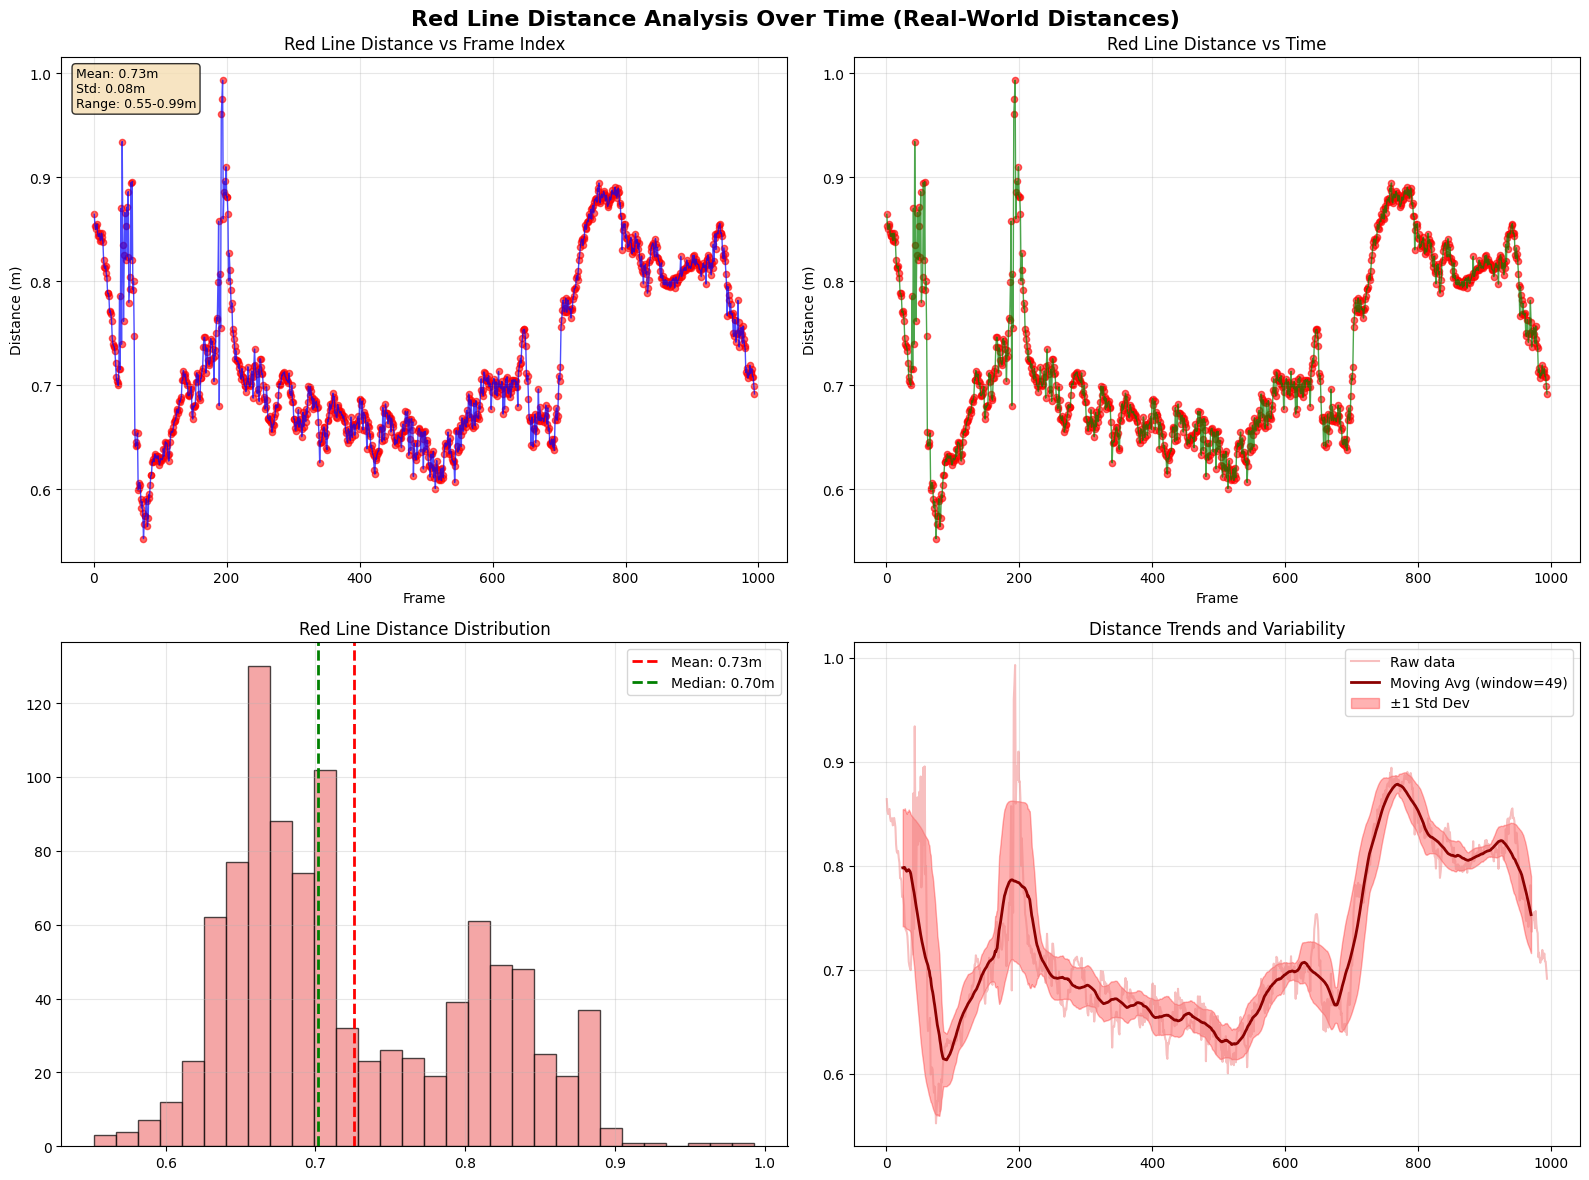

In [8]:
# Real-world distance analysis and plotting using utility function
image_shape = (700, 900)  # Update if your image size is different
sonar_coverage_meters = 10.0  # Update if your sonar coverage is different
iau.plot_real_world_distance_analysis(distance_results, image_shape=image_shape, sonar_coverage_meters=sonar_coverage_meters)

## Step 8: Timestamp Analysis

Let's examine the timestamps in detail and create time-based analysis of the fishing net distance.

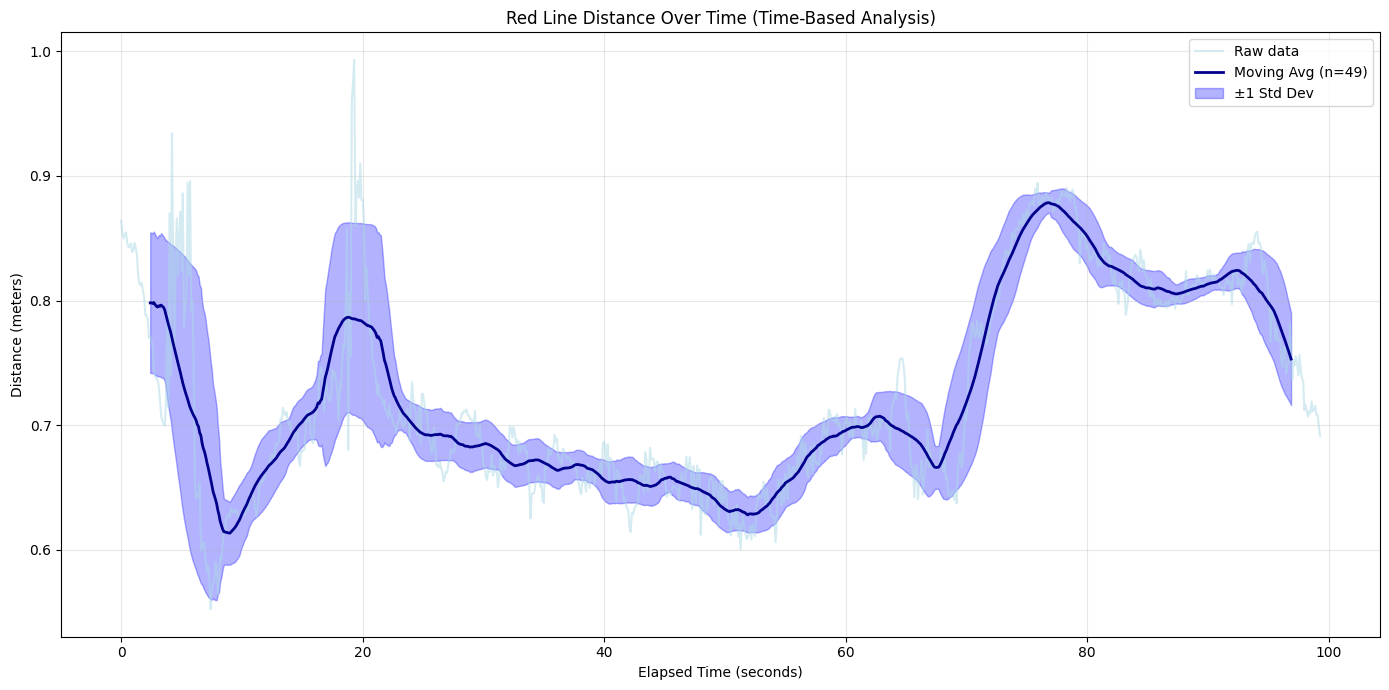

In [9]:
# Plot time-based analysis using utility function
iau.plot_time_based_analysis(distance_results, estimated_fps=10)

In [10]:
# 🔄 COMPARISON: SONAR vs DVL DISTANCE MEASUREMENTS
# =================================================
import utils.net_distance_analysis as sda

# Set target bag for comparison
EXPORTS_FOLDER = "/Users/eirikvarnes/code/SOLAQUA/exports"

print(f"🎯 LOADING DVL DATA FOR COMPARISON: {TARGET_BAG}")
print("=" * 60)

# Load all distance data for the target bag
raw_data, distance_measurements = sda.load_all_distance_data_for_bag(TARGET_BAG, EXPORTS_FOLDER)

# Display what we loaded
print(f"\n📊 RAW DATA LOADED:")
for key, data in raw_data.items():
    if data is not None:
        print(f"   ✅ {key}: {len(data)} records")
    else:
        print(f"   ❌ {key}: None")

print(f"\n📏 DISTANCE MEASUREMENTS LOADED:")
for key, info in distance_measurements.items():
    data_len = len(info['data'])
    print(f"   ✅ {key}: {data_len} records - {info['description']}")

🎯 LOADING DVL DATA FOR COMPARISON: 2024-08-22_14-29-05
🎯 LOADING ALL DISTANCE DATA FOR BAG: 2024-08-22_14-29-05
📡 1. Loading Navigation Data...
   ✅ Loaded 525 navigation records
📡 2. Loading Guidance Data...
   ✅ Loaded 518 guidance records with ['error_net_distance', 'desired_net_distance', 'r_net_distance_d']
📡 3. Loading DVL Altimeter...
   ✅ Loaded 31 DVL altimeter records
📡 4. Loading USBL...
   ✅ Loaded 29 USBL records
📡 5. Loading DVL Position...
   ✅ Loaded 284 DVL position records
📡 6. Loading Navigation Position...
   ✅ Loaded 269 navigation position records
📡 7. Loading INS Z Position...
   ✅ Loaded 562 INS records with positionFrame.z

📊 LOADING SUMMARY:
   🎯 Target bag: 2024-08-22_14-29-05
   📁 Raw data loaded: 2/2
   📏 Distance measurements: 6

📊 RAW DATA LOADED:
   ✅ navigation: 525 records
   ✅ guidance: 518 records

📏 DISTANCE MEASUREMENTS LOADED:
   ✅ DVL_Altimeter: 31 records - Distance to seafloor
   ✅ USBL_3D: 29 records - 3D acoustic position
   ✅ USBL_Depth: 29 

Error running detailed comparison: 'distance_meters_mavg'


/Users/eirikvarnes/code/SOLAQUA/venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/eirikvarnes/code/SOLAQUA/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


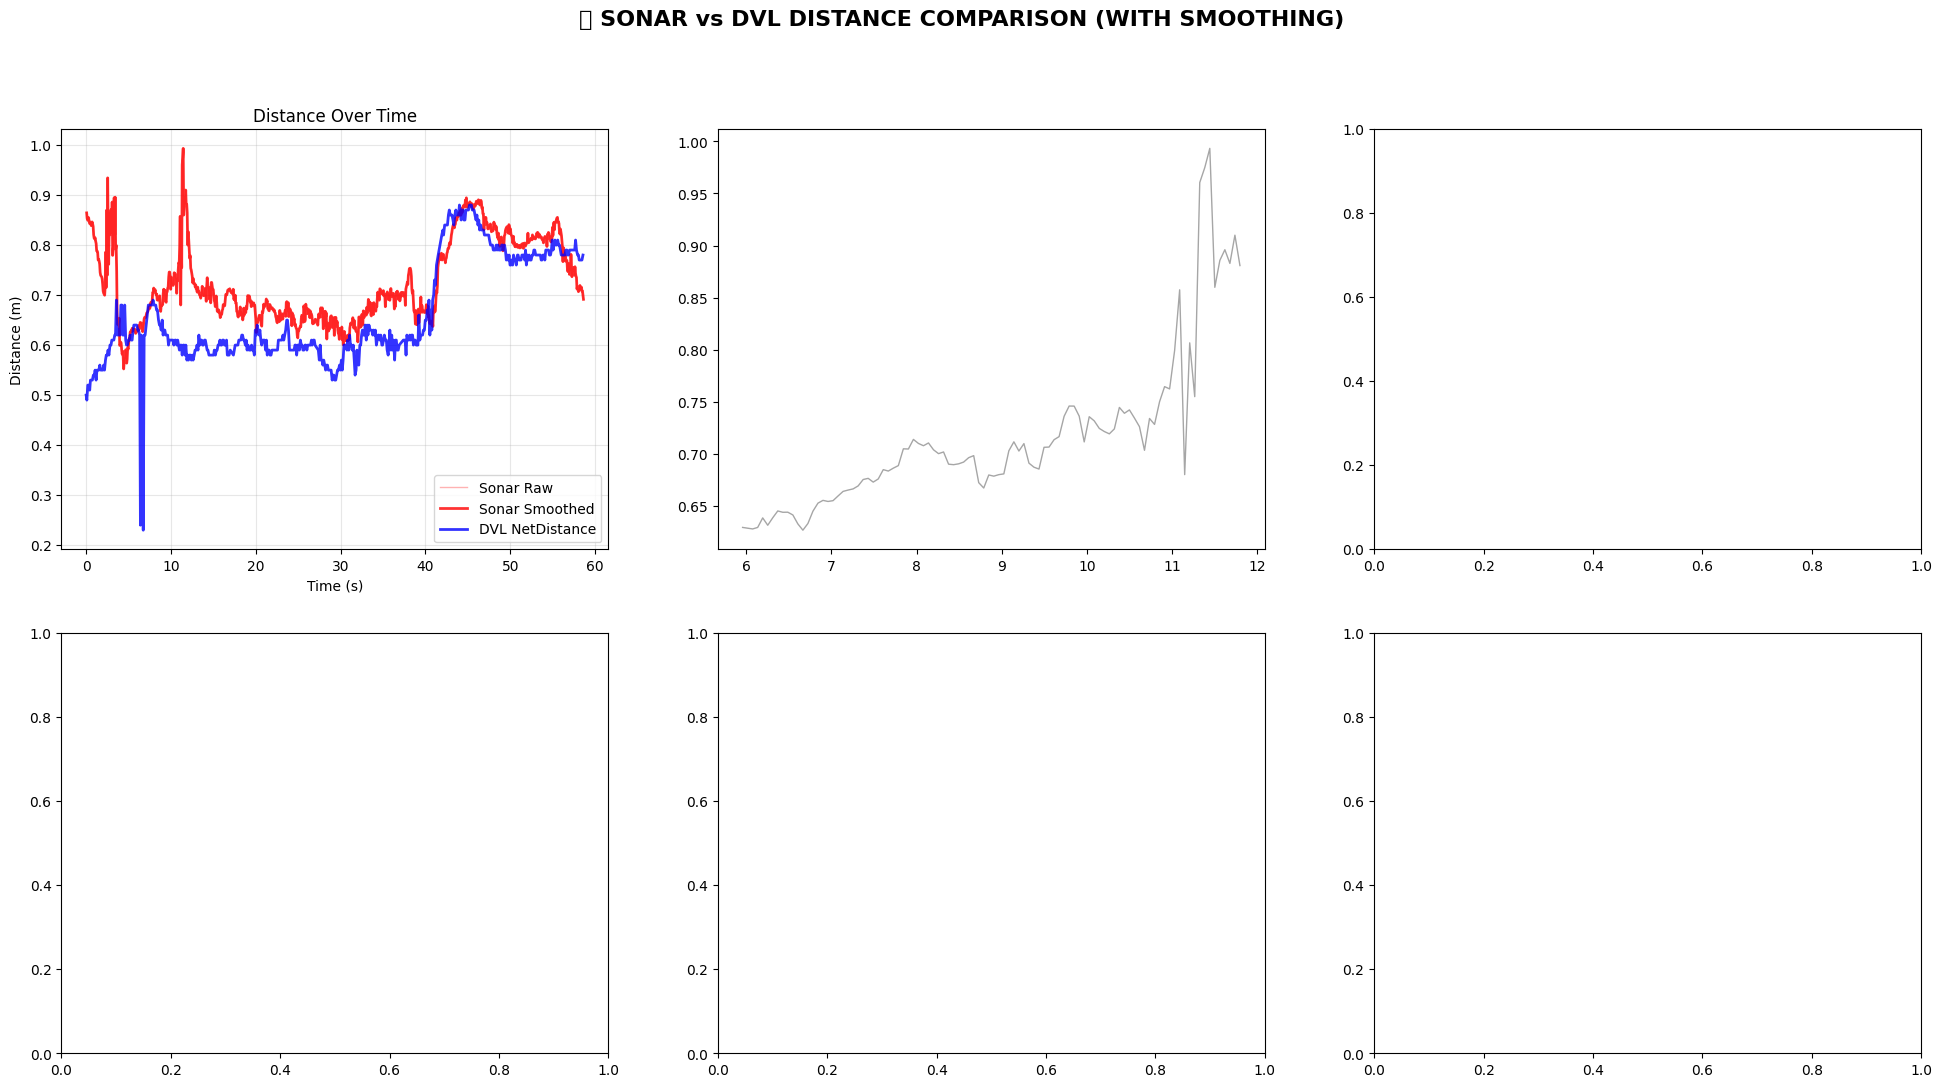

In [11]:
try:
    sonar_coverage_m = 10.0  # meters (adjust if needed)
    sonar_image_size = 700  # pixels (height used in sonar grid)
    fig, comparison_stats = iau.detailed_sonar_dvl_comparison(distance_results, raw_data, sonar_coverage_m=sonar_coverage_m, sonar_image_size=sonar_image_size, window_size=15)
    if comparison_stats and isinstance(comparison_stats, dict) and 'error' in comparison_stats:
        print('Comparison did not run:', comparison_stats['error'])
    else:
        print('\nComparison stats summary:')
        from pprint import pprint
        pprint(comparison_stats)
except Exception as e:
    print('Error running detailed comparison:', e)

In [12]:
# 🎥 Generate Video with Both DVL and Sonar Analysis Overlays
# ========================================================
import utils.sonar_and_foto_generation as sg
from pathlib import Path

# Set up paths
EXPORTS_FOLDER = Path("/Users/eirikvarnes/code/SOLAQUA/exports")
VIDEO_SEQ_DIR = None  # Set to path if you want camera footage included

print("🎬 GENERATING VIDEO WITH DUAL NET DISTANCE OVERLAYS")
print("=" * 60)
print(f"🎯 Target Bag: {TARGET_BAG}")
print(f"📊 DVL Data: {len(raw_data.get('navigation', []))} records")
print(f"📏 Sonar Analysis: {len(distance_results)} frames")
print(f"🎥 Camera: {'enabled' if VIDEO_SEQ_DIR else 'disabled'}")

# Generate the video with both overlays
try:
    video_path = sg.export_optimized_sonar_video(
        TARGET_BAG=TARGET_BAG,
        EXPORTS_FOLDER=EXPORTS_FOLDER,
        START_IDX=1,
        END_IDX=1000,  # Adjust as needed
        STRIDE=1,
        VIDEO_SEQ_DIR=VIDEO_SEQ_DIR,
        INCLUDE_NET=True,  # Enable DVL net distance overlay
        SONAR_DISTANCE_RESULTS=distance_results,  # Enable sonar analysis overlay
        NET_DISTANCE_TOLERANCE=0.5,
        NET_PITCH_TOLERANCE=0.3,
    )
    print(f"\n✅ Video generated successfully!")
    print(f"📁 Output: {video_path}")
except Exception as e:
    print(f"❌ Error generating video: {e}")

🎬 GENERATING VIDEO WITH DUAL NET DISTANCE OVERLAYS
🎯 Target Bag: 2024-08-22_14-29-05
📊 DVL Data: 525 records
📏 Sonar Analysis: 994 frames
🎥 Camera: disabled
🛠️ OPTIMIZED SONAR VIDEO
🎯 Target Bag: 2024-08-22_14-29-05
   Cone Size: 900x700
   Range: 0.0-5.0m | FOV: 120.0°
   🎥 Camera: disabled
   🕸  Net-line: enabled (dist tol=0.5s, pitch tol=0.3s)
   📊 Sonar Analysis: enabled
   Loading sonar data: sensor_sonoptix_echo_image__2024-08-22_14-29-05_video.csv
   ✅ Loaded 995 sonar frames in 8.98s
   ✅ Loaded 525 navigation records in 0.00s
      Available: ['NetDistance', 'NetPitch', 'timestamp']
   Frames: 1..994 (step 1) => 994
   Natural FPS: 15.9
   ✅ Loaded 995 sonar frames in 8.98s
   ✅ Loaded 525 navigation records in 0.00s
      Available: ['NetDistance', 'NetPitch', 'timestamp']
   Frames: 1..994 (step 1) => 994
   Natural FPS: 15.9

🎉 DONE! Wrote 994 frames to /Users/eirikvarnes/code/SOLAQUA/exports/videos/2024-08-22_14-29-05_optimized_sync_withsonar_20240822_142907_577071+0200.mp